In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt


In [2]:
def get_full_data(X,y):
    y_full_mask = ~np.isnan(y)
    X=X[y_full_mask]
    y=y[y_full_mask]
    return X,y

In [3]:
# load data
df = pd.read_csv("dataset/steel_strength.csv")
# get dependent and independent features
X=df.iloc[:,1:-3]
y=df.iloc[:,-2]
X,y = get_full_data(X,y)

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from common import XGB_search_params
from xgboost import XGBRegressor

r2_scoring = metrics.make_scorer(metrics.r2_score)

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBRegressor(device='cpu',max_bin=1024)

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=500,
    cv=5,
    random_state=state,
    n_jobs=-1,
    scoring=r2_scoring
)
search.fit(X,y)
special_model=search.best_estimator_

In [7]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score
def cross_val_score_mean_std(scores,name):
    print(f"-----------{name}-----------")
    print("Mean ",np.mean(scores))
    print("Std ",np.std(scores))

special_model.device='cpu'
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=50)

print("r2 scoring")
cross_val_score_mean_std(cross_val_score(special_model,X,y,cv=cv,scoring=r2_scoring),y.name)

r2 scoring
-----------tensile strength-----------
Mean  0.8516725498503617
Std  0.057470818435776456


In [25]:
from common import run_iteration

def find_outliers(
        X,y,special_model,
        outlier_remove_partition = 0.05,
        pred_scoring=metrics.mean_absolute_error,
        evaluate_scoring=metrics.r2_score,
        cv=6,
        repeats=3,
        iterations = 5,
        seed = 42,
        plot=False):
    """
    Finds outliers in a data by repeatedly fitting a special model and selecting samples with worst prediction performance as outliers.
    
    X: input 2-dim data

    y: output 1-dim data

    special_model: model which is used to determine samples with highest error
    outlier_remove_partition: which fraction of left non-outlier samples to remove in each iteration
    
    pred_scoring: scoring used for samples. Higher values means sample is more likely to be an outlier
    evaluate_scoring: scoring used for model performance evaluation
    cv: integer, how many folds to do on cross-validations to do on model fitting
    
    repeats: integer, how many cross-validations to do. Each repeat shuffles data runs cross-validation on it again and
    then algorithm averages predictions from all such repeats.
    
    iterations: how many iterations to do
    
    seed: algorithm random seed
    
    plot: render results or not
    
    Returns: array of outlier indices, total score of model prediction with given outliers removed
    """
    outliers=[]
    prev_outliers = []
    prev_score = -float('inf')

    stack_count = 0

    for iteration in range(iterations):
        X_cleaned = [row for i,row in enumerate(X) if i not in outliers]
        y_cleaned = [row for i,row in enumerate(y) if i not in outliers]

        X_cleaned=np.array(X_cleaned)
        y_cleaned=np.array(y_cleaned)

        pred, total = run_iteration(
            X=X_cleaned,
            y=y_cleaned,
            model=special_model,
            pred_scoring=pred_scoring,
            evaluate_scoring=evaluate_scoring,
            cv=cv,
            repeats=repeats,
            seed=seed)
        if plot: print("total error ",total)

        if total<prev_score: 
            outliers=[o for o in outliers if o not in prev_outliers]
            prev_outliers=[]
            outlier_remove_partition/=2
            stack_count+=1
            if stack_count>=2: break
            continue
        stack_count=0
        seed += iteration
        prev_score=total

        indices = np.argsort(-pred)
        to_remove_count = int(outlier_remove_partition*len(indices))
        if to_remove_count==0: break

        prev_outliers=indices[:to_remove_count]
        outliers=np.concatenate([outliers,prev_outliers])

        if not plot: continue
        indices=indices[:25]
        x=np.arange(0,len(indices))
        plt.figure(figsize=(8,5))
        plt.plot(x,pred[indices])
        plt.xticks(x,labels=indices)
        plt.xlabel("Sample")
        plt.ylabel("Prediction error")
        plt.show()
    if plot: print("total removed ",len(outliers))
    return np.array(outliers,dtype=np.int32), total

total error  0.8617326492450678


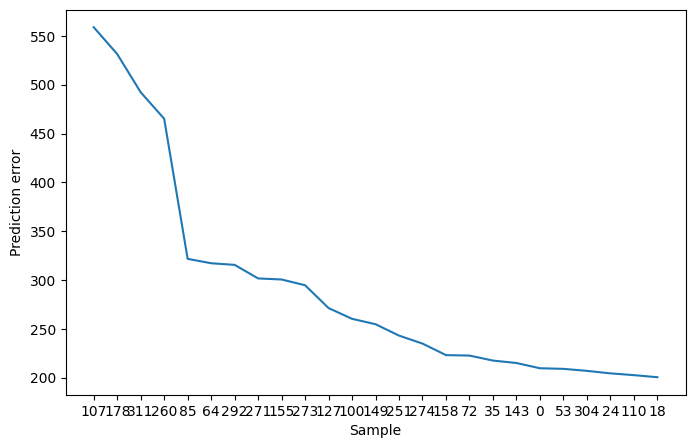

total error  0.8899626543713541


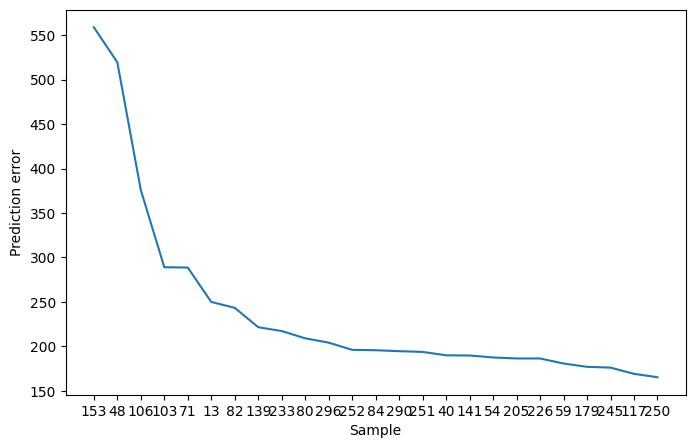

total error  0.8930374338731498


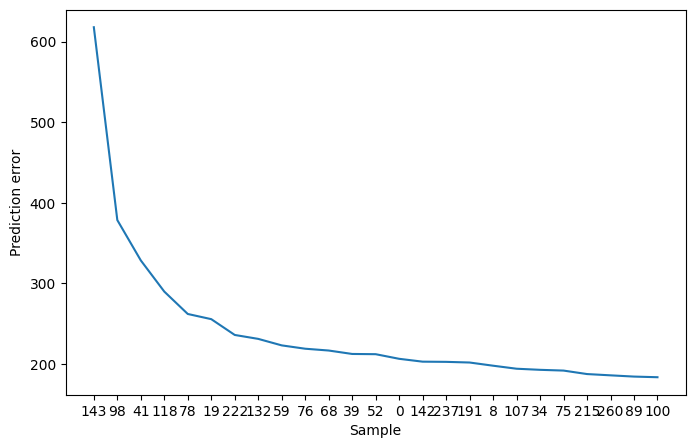

total error  0.8897202200008726
total error  0.8973708413529531


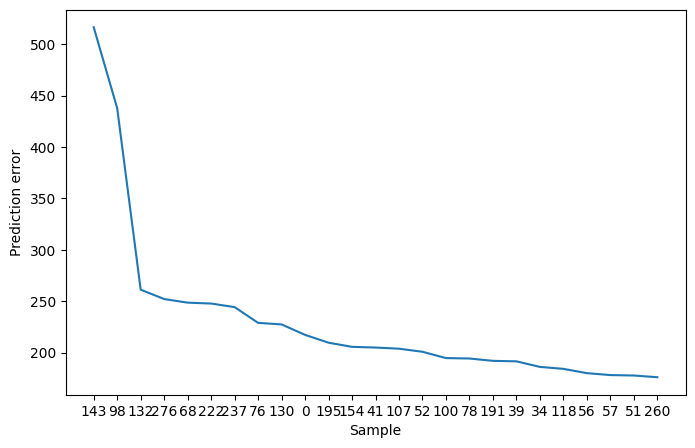

total removed  36


(array([107., 178., 311., 260.,  85.,  64., 292., 271., 155., 273., 127.,
        100., 149., 251., 274., 153.,  48., 106., 103.,  71.,  13.,  82.,
        139., 233.,  80., 296., 252.,  84., 290., 143.,  98., 132., 276.,
         68., 222., 237.]),
 0.8973708413529531)

In [24]:
find_outliers(X.to_numpy(),y,special_model,plot=True)

In [1]:
from gui_class import *
from xgboost import XGBRegressor

root = tk.Tk()

large_font = font.Font(family='Helvetica', size=20, weight='bold')

special_model = XGBRegressor(device='cpu',max_bin=1024)
main = MainWindow(root,special_model,large_font)   


root.mainloop()